#실행전 준비

데이터 출처: https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=580

In [ ]:
# pip installs
!pip install -q -U transformers bitsandbytes protobuf
!pip install -q -U peft trl matplotlib wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 12.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.33.1 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.33.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB

In [ ]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#패키지 사용을 위한 파일 업로드
from google.colab import files

src = list(files.upload().values())[0]
open('make_data2.py','wb').write(src)

Saving make_data2 (7).py to make_data2 (7).py


8329

#라이브러리 import

In [ ]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr
from datasets import load_dataset,Dataset, DatasetDict

from make_data2 import Datasetup

import numpy as np


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

`torch_dtype` is deprecated! Use `dtype` instead!


config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

In [ ]:
from pathlib import Path
root = "구글 드라이브 경로"

In [ ]:
os.listdir(root)

['01.민사', '02.형사', '03.행정']

#json 파일 로드

In [ ]:
from pathlib import Path
import os
import json


ROOT = Path("구글 드라이브 경로")

def iter_json_paths(root: str | Path, pattern: str = "*.json"):
    root = Path(root)
    # rglob 결과를 정렬해서 순서를 고정
    for p in sorted(root.rglob(pattern)):
        yield p

def load_json_file(path: Path, encoding: str = "utf-8"):
    try:
        with path.open("r", encoding=encoding) as f:
            return json.load(f), path
    except json.JSONDecodeError as e:
        return {"__error__": "JSONDecodeError", "message": str(e)}, path
    except OSError as e:
        return {"__error__": "OSError", "message": str(e)}, path

def iter_json_objects(root: str | Path, pattern: str = "*.json", encoding: str = "utf-8"):
    for p in iter_json_paths(root, pattern):
        data, path = load_json_file(p, encoding=encoding)
        yield data, path


In [ ]:
#민사, 형사, 행정 나눠서 json 불러오기

civil_json_list = []
criminal_json_list = []
administration_json_list = []


folder_to_list = {
    "01.민사": civil_json_list,
    "02.형사": criminal_json_list,
    "03.행정": administration_json_list,
}

law_json_list = [civil_json_list, criminal_json_list, administration_json_list]

# 폴더 순회하면서 JSON 로드
# 1차 폴더(01.민사 / 02.형사 / 03.행정)도 sorted로 순서 고정
for folder_entry in sorted(ROOT.iterdir(), key=lambda p: p.name):
    if not folder_entry.is_dir():
        continue

    folder_name = folder_entry.name  # 예: "01.민사"

    if folder_name.startswith("01."):
        target_list = civil_json_list       # 민사
    elif folder_name.startswith("02."):
        target_list = criminal_json_list    # 형사
    elif folder_name.startswith("03."):
        target_list = administration_json_list  # 행정
    else:
        print("매핑되지 않은 폴더:", folder_name)
        continue

    # 연도 폴더들도 정렬
    for year_entry in sorted(folder_entry.iterdir(), key=lambda p: p.name):
        if not year_entry.is_dir():
            continue

        # year_entry 예: /content/.../01.민사/2017
        for obj, p in iter_json_objects(year_entry):
            print(p)
            if obj:
                target_list.append(obj)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/content/drive/MyDrive/law_ai/TL_1.판결문/01.민사/1981~2016/89나19684.json
/content/drive/MyDrive/law_ai/TL_1.판결문/01.민사/1981~2016/89나19844.json
/content/drive/MyDrive/law_ai/TL_1.판결문/01.민사/1981~2016/89나208.json
/content/drive/MyDrive/law_ai/TL_1.판결문/01.민사/1981~2016/89나23478.json
/content/drive/MyDrive/law_ai/TL_1.판결문/01.민사/1981~2016/89나25207.json
/content/drive/MyDrive/law_ai/TL_1.판결문/01.민사/1981~2016/89나25962.json
/content/drive/MyDrive/law_ai/TL_1.판결문/01.민사/1981~2016/89나3235.json
/content/drive/MyDrive/law_ai/TL_1.판결문/01.민사/1981~2016/89나40534.json
/content/drive/MyDrive/law_ai/TL_1.판결문/01.민사/1981~2016/89나4191.json
/content/drive/MyDrive/law_ai/TL_1.판결문/01.민사/1981~2016/89나4221.json
/content/drive/MyDrive/law_ai/TL_1.판결문/01.민사/1981~2016/89나45102.json
/content/drive/MyDrive/law_ai/TL_1.판결문/01.민사/1981~2016/89나46297.json
/content/drive/MyDrive/law_ai/TL_1.판결문/01.민사/1981~2016/89나4824.json
/content/drive/MyDriv

In [ ]:
# train, test, val 데이터 나누기

train_law_json_list = []
val_law_json_list = []
test_law_json_list = []

for law_list in law_json_list:#민사 형사 행정 데이터들을 고르게 분배해서 train test val에 나눠 넣기
    n = len(law_list)
    n_train = int(n * 0.8)
    n_val = int(n * 0.93)

    train_law_json_list.extend(law_list[:n_train])
    val_law_json_list.extend(law_list[n_train:n_val])
    test_law_json_list.extend(law_list[n_val:])

print(len(train_law_json_list))
print(len(val_law_json_list))
print(len(test_law_json_list))

6400
1040
561


In [ ]:
len(train_law_json_list)

6400

In [ ]:
train_law_json_list[0]['info']['caseField']

'1'

In [ ]:
test_law_json_list[1]

{'info': {'caseField': '1',
  'detailField': '1',
  'trailField': '1',
  'caseNm': '용선료청구의소',
  'courtNm': '서울중앙지방법원',
  'judmnAdjuDe': '2018. 07. 13.',
  'caseNo': '2017가합560423',
  'relateLaword': ['채무자회생법 제179조',
   '국제사법 제25조',
   '채무자회생법 제475조',
   '채무자회생법 제476조',
   '영국 상급법원법 제35조',
   '영국 판결법 제17조',
   '영국 집행법 제44조',
   '채무자회생법 제144조'],
  'qotatPrcdnt': ['서울중앙지방법원 2017하합15호',
   '대법원 2015. 5. 28. 선고 2012다104526, 104533 판결 ',
   '대법원 2007.6.29. 선고 2006다5130 판결',
   '대법원 2015.1.29. 선고 2012다108764 판결',
   '서울중앙지방법원 2016. 9. 1. 2016회합100211호']},
 'concerned': {'acusr': '2', 'dedat': '2'},
 'org': {'orgJdgmnCourtNm': '', 'orgJdgmnAdjuDe': '', 'orgJdgmnCaseNo': ''},
 'disposal': {'disposalform': '1',
  'disposalcontent': ['피고는 원고 000에 미화 1,175,417.24달러 및 이에 대하여 2016.10.21.부터 2018.7.13.까지는 연 6%, 그 다음날부터 다 갚는 날까지는 연 15%의 각 비율로 계산한 돈을 지급한다.',
   '피고는 원고 000에 미화 430,770.02달러 및 이에 대하여 2016.9.20.부터 2018.7.13.까지는 연 6%, 그 다음날부터 다 갚는 날까지는 연 15%의 각 비율로 계산한 돈을 지급한다.',
   '원고들의 나머지 청구를 각 기각한다.',


#데이터 전처리 실험

In [ ]:
import re
stuff = train_law_json_list[1]['assrs']['acusrAssrs']

stuff = str(stuff)
stuff = stuff.replace("\u3000", " ")
stuff = re.sub(r'[:\[\]"{}【】\s]+', ' ', stuff).strip()
stuff = stuff.replace(" ,", ",").replace(",,,",",").replace(",,",",").replace("'","")
stuff = re.sub(r"[ \t]+", " ", stuff)
stuff = re.sub(r"\s*\n\s*", "\n", stuff)
stuff = stuff.strip()
stuff

'① 원고가 망 소외 00에 대한 1차 수술 도중 대량의 출혈이 있었으나 망 소외 00이 000에 전원되어 피고 00에 의하여 자궁 적출술이 시행될 당시는 뇌사상태가 아니어서 소생가능성이 없는 상태가 아니었다고 주장한다., ② 피고 00은 미만성 혈액응고장애가 있는 경우 수혈을 계속하면서 이에 대한 항응고제를 투여하는 등 조치를 취하여야 함에도 1995. 10. 26. 23 30까지만 수혈을 하고 수혈을 중단하였고 오히려 수액에 에피네프린을 섞어 계속 투여하여 실혈사를 더욱 가속화시킨 과실로 망 소외 00이 사망하였다고 주장한다., ③ 1995. 10. 26. 23 15부터 다음날 01 39까지 약 2시간 사이에 약 2,000㏄나 되는 출혈이 있었는데, 이러한 양은 스며나오는 실혈인 우징(woozing)에 의하여는 불가능하므로 피고 00이 자궁적출술을 시행하면서 자궁을 들어낸 뒤 그 혈관 부위를 제대로 결찰하지 못한 과실로 인하여 수술부위를 봉합한 뒤 일부 결찰 부위가 터져 혈관을 통하여 다량의 출혈이 생긴 것으로 보인다고 주장한다., ④ 피고 00은 혈액응고장애를 판별하는 가장 중요한 FDP(Fibrinogen Degradation Product) 검사를 시행하지 못하게 한 과실이 있다고 주장한다., 따라서 망 소외 00은 전원 조치를 지연한 원고의 과실과 피고 00의 위와 같은 과실이 경합하여 과다출혈로 인한 저혈량성 쇼크로 사망하였고, 원고와 피고 00의 과실 비율은 20 80이다., 그렇다면 원고가 망 소외 00에게 손해배상금으로 1999. 6. 30. 금 100,076,462원 조정조서상 금액 52,000,000원＋공탁금 39,741,615원(원고가 주장한 금 39,746,115원은 오기로 보임)＋공탁금 8,334,847원 을 지급하였다., 피고들은 연대하여 원고에게 피고 00의 과실 비율에 해당하는 구상금 80,061,169원(금 100,076,462원×80%, 원 미만 버림) 및 이에 대한 원고가 구하는 최종 변제일인 1999. 6. 30.부터 완

#Datasetup 클래스 생성 실험

In [ ]:
#업로드한 make_data2 패키지의 Datasetup 클래스가 잘 동작하는지 확인
output1 = Datasetup(train_law_json_list[0])

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
output1.prompt

{'messages': [{'role': 'system',
   'content': '원고 측의 주장과 피고 측의 주장을 살펴보았을때, 내릴 수 있는 판결을 예측하여 관련 법조항과 결론을 작성해줘.'},
  {'role': 'user',
   'content': '사건유형 민사 세부유형 민사 2심 원고 측의 주장 요약 전라북도 완주군 공무원 완주군수가 허가처분 취소 후에도 최종허가처분을 하지 않아 재산적 손해와 정신적 손해를 배상해야 하는 상황이 발생했습니다. 이는 공무원의 직무상 의무를 제대로 이행하지 못하고, 결국 법적 책임을 져야 하는 것입니다. 피고 측의 주장 없음 기초사실 요약 전라북도에서 1995년부터 2011년까지 벌채 작업을 수행하며 토석채취량 1,523,149㎥를 채취한 회사(원고)는 완주군수의 토석채취 허가 과정에서 여러 문제점을 겪었습니다. 특히, 완주군수가 하천부지점용허가기간을 이유로 2013년 12월 31일까지 토석채취 허가 기간을 연장하도록 요구하며 허가 처분을 내렸고, 이는 환경영향평가 협의를 거치지 않고 진행된 것으로 판단되었습니다. 원고는 이러한 불합리한 처분에 대해 완주군수에 행정심판을 청구하며, 결국 완주군수는 허가 기간을 7년으로 제한하는 처분을 내렸습니다. 원고는 완주군수의 처분에 대해 환경보전 방안 협의서를 제출했지만, 완주군은 이를 거부했습니다. 이 과정에서 완주군은 2010년 3월 24일에 완주군수에 토석채취 허가 신청을 하고, 이후 2010년 8월 23일에 허가 기간을 7년으로 연장하려 했으나, 하천점용기간을 이유로 2013년 12월 31일까지 연장하도록 요구하며 허가 처분을 내린 것은 재결의 기속력에 반하는 처분으로 판단되어 원고에게 이행통지를 내리고, 환경보전 방안 협의서를 제출하지 않아 환경보전 방안 협의서를 제출하지 못했습니다.'},
  {'role': 'assistant',
   'content': '관련 법조항 환경영향평가법 제22조 환경영향평가법 시행령 제32조 산지관리법 시행령 제32조 구 행정심판법(

In [ ]:
output1.test_prompt

{'messages': [{'role': 'system',
   'content': '원고 측의 주장과 피고 측의 주장을 살펴보았을때, 내릴 수 있는 판결을 예측하여 관련 법조항과 결론을 작성해줘.'},
  {'role': 'user',
   'content': '사건유형 민사 세부유형 민사 2심 원고 측의 주장 요약 전라북도 완주군 공무원 완주군수가 허가처분 취소 후에도 최종허가처분을 하지 않아 재산적 손해와 정신적 손해를 배상해야 하는 상황이 발생했습니다. 이는 공무원의 직무상 의무를 제대로 이행하지 못하고, 결국 법적 책임을 져야 하는 것입니다. 피고 측의 주장 없음 기초사실 요약 전라북도에서 1995년부터 2011년까지 벌채 작업을 수행하며 토석채취량 1,523,149㎥를 채취한 회사(원고)는 완주군수의 토석채취 허가 과정에서 여러 문제점을 겪었습니다. 특히, 완주군수가 하천부지점용허가기간을 이유로 2013년 12월 31일까지 토석채취 허가 기간을 연장하도록 요구하며 허가 처분을 내렸고, 이는 환경영향평가 협의를 거치지 않고 진행된 것으로 판단되었습니다. 원고는 이러한 불합리한 처분에 대해 완주군수에 행정심판을 청구하며, 결국 완주군수는 허가 기간을 7년으로 제한하는 처분을 내렸습니다. 원고는 완주군수의 처분에 대해 환경보전 방안 협의서를 제출했지만, 완주군은 이를 거부했습니다. 이 과정에서 완주군은 2010년 3월 24일에 완주군수에 토석채취 허가 신청을 하고, 이후 2010년 8월 23일에 허가 기간을 7년으로 연장하려 했으나, 하천점용기간을 이유로 2013년 12월 31일까지 연장하도록 요구하며 허가 처분을 내린 것은 재결의 기속력에 반하는 처분으로 판단되어 원고에게 이행통지를 내리고, 환경보전 방안 협의서를 제출하지 않아 환경보전 방안 협의서를 제출하지 못했습니다.'}]}

In [ ]:
output1.token_count

617

#데이터 분할 생성

밑 코드들은 준비된 데이터를 Datasetup 클래스를 이용하여 프롬프트를 생성하는 코드이다.

다만 colab의 런타임이 자주 끊겨서
데이터들을 나눠서 프롬프트 생성을 진행 후 pkl 파일로 저장했다.



In [ ]:
from tqdm import tqdm
val_data = []
for data in tqdm(val_law_json_list[250:500]):
    val_data.append(Datasetup(data))

100%|██████████| 250/250 [2:27:51<00:00, 35.49s/it]


In [ ]:
import pickle
with open('/content/drive/MyDrive/law_ai/pickle/val[250:500].pkl', 'wb') as file:
    pickle.dump(val_data, file)

In [ ]:
from tqdm import tqdm
val_data = []
for data in tqdm(val_law_json_list[500:750]):
    val_data.append(Datasetup(data))

100%|██████████| 250/250 [1:46:08<00:00, 25.47s/it]


In [ ]:
import pickle
with open('/content/drive/MyDrive/law_ai/pickle/val[500:750].pkl', 'wb') as file:
    pickle.dump(val_data, file)

In [ ]:
from tqdm import tqdm
val_data = []
for data in tqdm(val_law_json_list[750:1040]):
    val_data.append(Datasetup(data))

100%|██████████| 290/290 [2:23:35<00:00, 29.71s/it]


In [ ]:
import pickle
with open('/content/drive/MyDrive/law_ai/pickle/val[750:1040].pkl', 'wb') as file:
    pickle.dump(val_data, file)

In [ ]:
from tqdm import tqdm
test_data = []
for data in tqdm(test_law_json_list[:250]):
    test_data.append(Datasetup(data))

100%|██████████| 250/250 [2:22:15<00:00, 34.14s/it]


In [ ]:
import pickle
with open('/content/drive/MyDrive/law_ai/pickle/test[:250].pkl', 'wb') as file:
    pickle.dump(test_data, file)

In [ ]:
from tqdm import tqdm
test_data = []
for data in tqdm(test_law_json_list[250:]):
    test_data.append(Datasetup(data))

100%|██████████| 311/311 [2:26:30<00:00, 28.26s/it]


In [ ]:
import pickle
with open('/content/drive/MyDrive/law_ai/pickle/test[250:].pkl', 'wb') as file:
    pickle.dump(test_data, file)

In [ ]:
from tqdm import tqdm
train_data = []
test_data = []
for data in tqdm(train_law_json_list[5500:5750]):
    train_data.append(Datasetup(data))

100%|██████████| 250/250 [2:23:20<00:00, 34.40s/it]


In [ ]:
import pickle
with open('/content/drive/MyDrive/law_ai/pickle/train[5500:5750].pkl', 'wb') as file:
    pickle.dump(train_data, file)

In [ ]:
from tqdm import tqdm
train_data = []
test_data = []
for data in tqdm(train_law_json_list[5750:6000]):
    train_data.append(Datasetup(data))

100%|██████████| 250/250 [2:14:51<00:00, 32.36s/it]


In [ ]:
import pickle
with open('/content/drive/MyDrive/law_ai/pickle/train[5750:6000].pkl', 'wb') as file:
    pickle.dump(train_data, file)

In [ ]:
from tqdm import tqdm
train_data = []
test_data = []
for data in tqdm(train_law_json_list[6000:6250]):
    train_data.append(Datasetup(data))

100%|██████████| 250/250 [2:13:26<00:00, 32.03s/it]


In [ ]:
import pickle
with open('/content/drive/MyDrive/law_ai/pickle/train[6000:6250].pkl', 'wb') as file:
    pickle.dump(train_data, file)

In [ ]:
#train[:1000] 까지완료

from tqdm import tqdm
train_data = []
test_data = []
for data in tqdm(train_law_json_list[6250:6500]):
    train_data.append(Datasetup(data))

100%|██████████| 150/150 [1:16:00<00:00, 30.41s/it]


In [ ]:
import pickle
with open('/content/drive/MyDrive/law_ai/pickle/train[6250:6500].pkl', 'wb') as file:
    pickle.dump(train_data, file)

In [ ]:
from tqdm import tqdm
train_data = []
test_data = []
for data in tqdm(train_law_json_list[6500:6750]):
    train_data.append(Datasetup(data))

In [ ]:
import pickle
with open('/content/drive/MyDrive/law_ai/pickle/train[6500:6750].pkl', 'wb') as file:
    pickle.dump(train_data, file)

In [ ]:
from tqdm import tqdm
train_data = []
test_data = []
for data in tqdm(train_law_json_list[6750:7000]):
    train_data.append(Datasetup(data))

0it [00:00, ?it/s]


In [ ]:
import pickle
with open('/content/drive/MyDrive/law_ai/pickle/train[6750:7000].pkl', 'wb') as file:
    pickle.dump(train_data, file)

In [ ]:
from tqdm import tqdm
train_data = []
test_data = []
for data in tqdm(train_law_json_list[4500:4750]):
    train_data.append(Datasetup(data))

100%|██████████| 250/250 [1:58:04<00:00, 28.34s/it]


In [ ]:
import pickle
with open('/content/drive/MyDrive/law_ai/pickle/train[4500:4750].pkl', 'wb') as file:
    pickle.dump(train_data, file)

In [ ]:
from tqdm import tqdm
train_data = []
test_data = []
for data in tqdm(train_law_json_list[4750:5000]):
    train_data.append(Datasetup(data))

100%|██████████| 250/250 [1:53:56<00:00, 27.35s/it]


In [ ]:
import pickle
with open('/content/drive/MyDrive/law_ai/pickle/train[4750:5000].pkl', 'wb') as file:
    pickle.dump(train_data, file)

#파일이 잘 저장되었는지 확인

In [ ]:
with open("/content/drive/MyDrive/law_ai/pickle/train[6000:6250].pkl","rb") as fr:
    data = pickle.load(fr)




In [ ]:
data[1].prompt

{'messages': [{'role': 'system',
   'content': '원고 측의 주장과 피고 측의 주장을 살펴보았을때, 내릴 수 있는 판결을 예측하여 관련 법조항과 결론을 작성해줘.'},
  {'role': 'user',
   'content': '사건유형 행정 세부유형 행정 1심 원고 측의 주장 요약 구 부가치세법 제16조 1항에 따라 세금계산서 발행 시 사업자 등록 번호와 성명을 기재해야 한다. 개인사업자는 성명 란에 기재하는 것이 필요적 기재사항 요건에 해당하며, 세금계산서 납부세액 산정에도 문제가 없다. 따라서 이 사건 세금계산서는 부과제척 기간이 적용되는 과세처분으로 인해 무효이다. 피고 측의 주장 없음 기초사실 ## 법률용어 없이 요약 2006년부터 2012년까지 부가가치세 과세 기간 동안, 000과 000는 인테리어 업체로부터 매입세금계산서를 받았습니다. 이 세금계산서 중 일부는 불공정하게 처리되어 법인세법상 증빙불비가산세를 적용하여 부가가치세 및 법인세를 부과한 것입니다. 즉, 부가가치세와 관련된 세금계산서가 제대로 계산되지 않아 원고들이 어려움을 겪고 있습니다.'},
  {'role': 'assistant',
   'content': '관련 법조항 구 부가가치세법(2013. 1. 1. 법률 제11608호로 개정되기 전의 것)제16조 구 부가가치세법(2013. 1. 1. 법률 제11608호로 개정되기 전의 것)제17조 국세기본법 제14조 국세기본법 제26조의2 결론 피고 금천세무서장이 2013. 9. 16. 원고 000에게 한 2006년 2기부터 2008년1기까지의 부가가치세 부과처분을 취소한다. 피고 금천세무서장이 2013. 6. 7. 원고 000에게 한 2006년 2기부터 2007년 2기까지의 부가가치세 부과처분은 무효임을 확인한다. 원고 000의 피고 북대구세무서장, 동안양세무서장에 대한 청구 및 원고들의 피고금천세무서장에 대한 나머지 청구를 모두 기각한다. 소송비용 중 1. 원고 000과 피고 금천세무서장 사이에 생긴 부분

#프롬프트의 토큰 분포 확인

In [ ]:
max_1 = 0
count = 0
for data in train_data:
    if data.token_count > max_1:
        max_1 = data.token_count
        if max_1> 8000:
            count += 1

In [ ]:
print(max_1, count)

1080 0


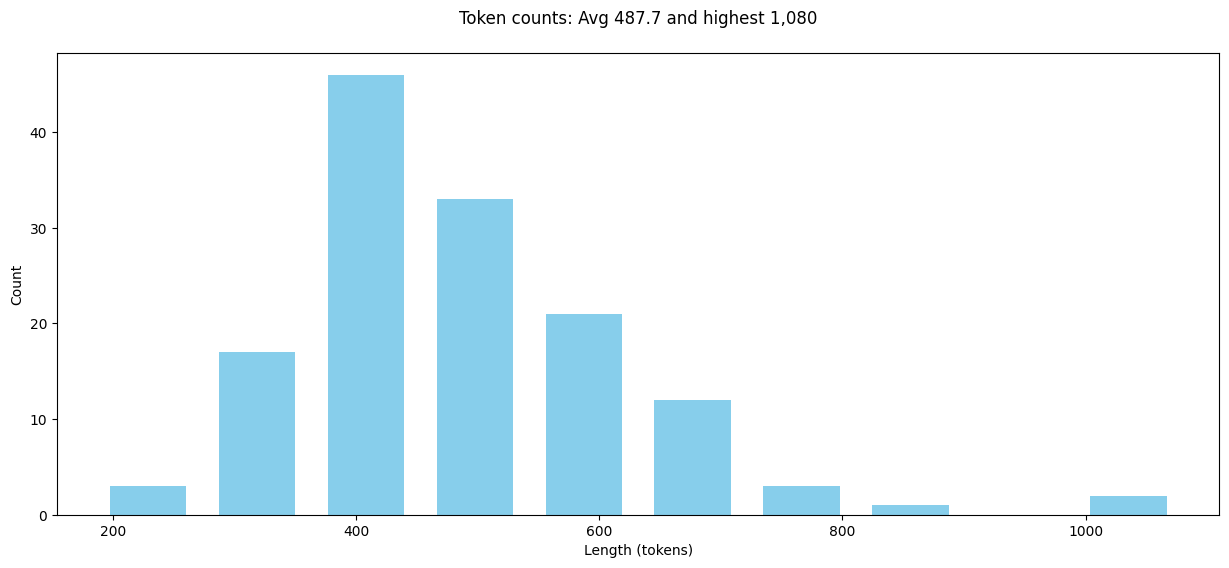

In [ ]:
# Plot the distribution of token counts again
import matplotlib.pyplot as plt

tokens = [item.token_count for item in train_data]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue")
plt.show()